## 0.Getting setup

In [3]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121


In [4]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [5]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1.Get Data

Replicating ViT architecture for FoodVision Mini Problem.


In [6]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [7]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2.Create Dataset and Dataloaders

In [8]:
from going_modular.going_modular import data_setup

# Create Image size
IMG_SIZE = 224

# create transform pipline
manaul_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()

])
print(f"Manually created Tensor : {manaul_transform}")

Manually created Tensor : Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [9]:
# create a batch size of 32 (the paper uses a batch size of 4096, which is pretty big)
BATCH_SIZE = 32

# Create dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manaul_transform,
    batch_size = BATCH_SIZE
)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.1 Visualizing a Single Image



In [10]:
import random # Import the random module
random.seed(42) # Use the correct function to set the random seed
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

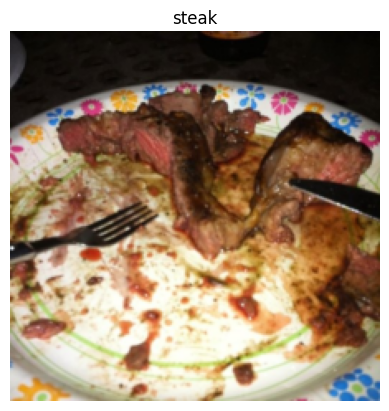

In [11]:
## Plot the image
import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0)) # (color_channels, height, width) -> (height, width, color_channels)
plt.title(class_names[label])
plt.axis(False)

## 3.Replicating ViT : Overview

* **Inputs** - What goes into our model (In out case we have image tensors)
* **Output** - what comes out of the layer/block/model (In our case we want the model to output image classification labels)
* **Layers** - Take an input, manipulates it with a function(for ex self-attention)
* **Blocks** - A Collection of layers
* **Model** - A collection of blocks

### 3.1 ViT Overview : Pieces of the architecture

* Figure 1 : Visual overview of the architecture
* Four Equations
* Table 1/3 : Different hyperparameters


#### Figure 1

![](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-figure-1-architecture-overview.png)

* Extra learnable class embedding - The class embedding allows the Vision Transformer to transform the high-dimensional patch representations into a single vector that encapsulates the overall content of the image, enabling accurate image classification.

#### Four equations
![](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-four-equations.png)

* **Equation 1:**
* Positional embedding are added to patch emedding to retain positional information.

```python
x_input = [class_token, image_patch_1, image_patch_2, ..... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos ..... image_patch_N_pos]
```
#### Table 1
![](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-table-1.png)


## 4.Equation 1: Split data into patches and creating the class, position, Patch embedding

* Input shapes : (H, W, C)
* Output Shapes : N x (P^2 x C)
* H - Height
* W - Width
* C - Color channels
* N - Number of patches (height*width) / p^2
* P - Patche size




In [12]:
height = 224
width = 224
color_channels = 3
patch_size = 16

# calculate the number of patches i.e N
number_of_patches = int((height*width) // patch_size**2)
number_of_patches

196

In [13]:
 ## An example
embedding_layer_input_shape = (height, width, color_channels)

# output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape : {embedding_layer_input_shape}")
print(f"Output shape : {embedding_layer_output_shape}")

Input shape : (224, 224, 3)
Output shape : (196, 768)


### 4.1 Turning a single image into patches


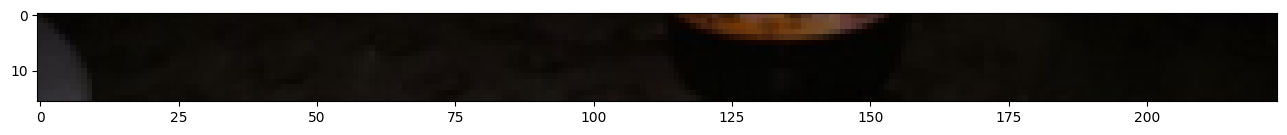

In [14]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)

# Index to plot  the top row of pixels
patch_size = 16
plt.figure(figsize = (patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row : 14.0
 Patch size : 16 x 16
0
16
32
48
64
80
96
112
128
144
160
176
192
208


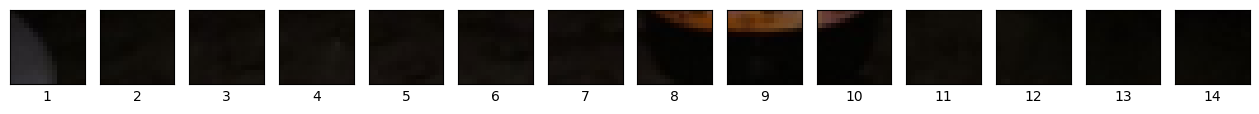

In [15]:
# Top row as patchs
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size should be divisible by patch size"
print(f"Number of patches per row : {num_patches}\n Patch size : {patch_size} x {patch_size}")

fig, axs = plt.subplots(nrows = 1, ncols = img_size // patch_size, sharex = True, sharey = True, figsize = (patch_size, patch_size))

# value of patch
for i, patch in enumerate(range(0, img_size, patch_size)):
  print(patch)
# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]) # i.e from [height = 16, width = 0 + 16 = 16, Color_Channels = 3]]
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])


Number of patches per row : 14.0
 Patch size : 16 x 16


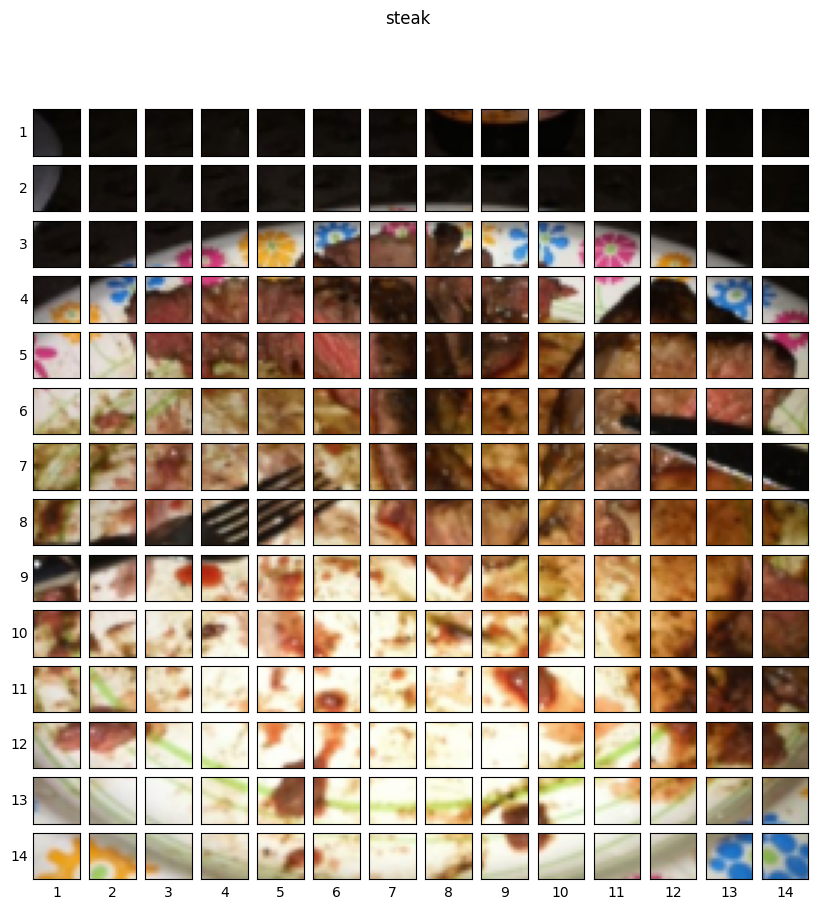

In [16]:
# setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size should be divisible by patch size"
print(f"Number of patches per row : {num_patches}\n Patch size : {patch_size} x {patch_size}")

# create a series of subplots
fig, axs = plt.subplots(nrows = img_size // patch_size, ncols = img_size // patch_size, sharex = True, sharey = True, figsize = (10, 10))

# Loop through height and width of the image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])

    # setup labels
    axs[i,j].set_ylabel(i+1, rotation = "horizontal", horizontalalignment = "right", verticalalignment = "center")
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()

fig.suptitle(f"{class_names[label]}")
plt.show()


### 4.2 Creating image patches and turning them into patch embeddings

* This can be done when our kernel size and stride is same as the size of patch of image (i.e 16), so that when the kernel iterate overs the patches of the images it can be flatterned easily just by applying `nn.Flattern`.

In [17]:
# create conv2d layer to turn image into patches of learnable feature maps
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels = 3, out_channels = 768, kernel_size = patch_size, stride = patch_size, padding = 0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [18]:
# Pass the image through convolution layer
image_out_of_conv2d = conv2d(image.unsqueeze(0))
image_out_of_conv2d.shape

## the values are obtained in such a way when kernel iterate over the patches it would result in same number since the size of kernel is same as patches


torch.Size([1, 768, 14, 14])

### 4.3 Flattening the patch embedding with `torch.nn.Flatten()`

* The input shape of the image is `torch.Size([1, 768, 14, 14])` -> [batch_size, embedding_dim, kernal_height, kernel_width]

* The required shape is [number_of_patch, embedding_dim] i.e `torch.Size([196, 768])`

In [19]:
image_out_of_conv2d.shape
# required shape -> [1, 768, 196]

torch.Size([1, 768, 14, 14])

In [20]:
from torch import nn
flatten_layer = nn.Flatten(start_dim = 2, end_dim = 3)
image_out_conv_flatten = flatten_layer(image_out_of_conv2d)
image_out_conv_flatten.shape

torch.Size([1, 768, 196])

In [21]:
image_out_conv_flatten.permute(0, 2, 1).shape

torch.Size([1, 196, 768])

### 4.4 Turning the ViT patch embedding layer into a PyTorch Module

We want this module to do a few things:
1. Create a class called `PatchEmbedding` that inherits from `nn.Module`.
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedded patches using `nn.Conv2d()`.
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `foward()` that defines the forward computation (e.g. pass through layer from 3 and 4).
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.


**NOTE** - Main function for patch embedding

In [22]:
# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
  # 2. Initilaize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768): # from Table 1 for ViT-Base
    super().__init__()

    self.patch_size = patch_size

    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # 4. Create a layer to flatten feature map outputs of Conv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  # 5. Define a forward method to define the forward computation steps
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # 6. Make the returned sequence embedding dimensions are in the right order (batch_size, number_of_patches, embedding_dimension)
    return x_flattened.permute(0, 2, 1)


In [23]:
set_seeds()

# create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels = 3, patch_size = 16, embedding_dim = 768)

# Pass a single image through patch embedding
patch_embedded_image = patchify(image.unsqueeze(0))
patch_embedded_image.shape

torch.Size([1, 196, 768])

### 4.5 Creating the token embedding

* Prepend a learnable class token to the start of the patch embedding

In [24]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]


In [25]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension
class_token = nn.Parameter(torch.randn(1, 1, embedding_dimension), requires_grad = True)
class_token.shape


torch.Size([1, 1, 768])

In [26]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_token = torch.cat((class_token.repeat(batch_size, 1, 1), patch_embedded_image), dim = 1)
print(f"{patch_embedded_image_with_class_token.shape} -> [batch_size, class_token + num_of_patches, embedding_dim]")
patch_embedded_image_with_class_token

# the extra 1 in size (i.r from 196 to 197, the first is the extra learnable parameter)

torch.Size([1, 197, 768]) -> [batch_size, class_token + num_of_patches, embedding_dim]


tensor([[[ 0.5436, -0.4700, -1.2133,  ..., -0.4571,  0.4486,  0.1217],
         [-0.0479, -0.0215, -0.0775,  ...,  0.0433, -0.0248,  0.0849],
         [-0.0769, -0.0055, -0.0446,  ...,  0.0484, -0.0262,  0.0156],
         ...,
         [-0.5915,  0.0859, -0.2666,  ...,  0.6136, -0.3583,  0.2102],
         [-0.3818,  0.1991, -0.3771,  ...,  0.3984, -0.0655,  0.2059],
         [-0.5226,  0.2265, -0.3347,  ...,  0.2311, -0.2311,  0.2656]]],
       grad_fn=<CatBackward0>)

### 4.6 Creating Positional Embedding

* Create a series of 1D learnable positional embedding and to add them to the sequence of patch embedding.


In [27]:
# calculate N (number of patches)
number_of_patches = int((height * width) // (patch_size**2))

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_token.shape[-1]

# Create a 1D Learnable position embedding
position_embedding = nn.Parameter(torch.randn(1, number_of_patches + 1, embedding_dimension))
print(f"{position_embedding}")
print(f"{position_embedding.shape}")



Parameter containing:
tensor([[[-1.0264, -2.4631,  0.1703,  ...,  0.1468,  1.3768,  0.5802],
         [-0.6950,  0.7188, -1.1410,  ..., -0.3153, -2.2221, -0.6922],
         [-1.5855, -0.3176, -1.4012,  ...,  1.7983,  0.5078,  0.0315],
         ...,
         [ 1.2855,  0.8303,  0.1497,  ..., -0.4751,  1.2664,  0.6758],
         [-0.0406, -0.5170, -0.3489,  ..., -0.4922,  0.3503,  1.3471],
         [-0.2454, -0.0047,  1.4984,  ..., -0.4075,  1.5785, -0.3281]]],
       requires_grad=True)
torch.Size([1, 197, 768])


In [28]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_token + position_embedding
print(f"{patch_and_position_embedding}")
print(f"{patch_and_position_embedding.shape}")

tensor([[[-0.4828, -2.9331, -1.0430,  ..., -0.3104,  1.8254,  0.7019],
         [-0.7429,  0.6974, -1.2184,  ..., -0.2720, -2.2469, -0.6073],
         [-1.6624, -0.3231, -1.4458,  ...,  1.8466,  0.4816,  0.0471],
         ...,
         [ 0.6940,  0.9162, -0.1169,  ...,  0.1384,  0.9081,  0.8860],
         [-0.4224, -0.3180, -0.7260,  ..., -0.0938,  0.2847,  1.5530],
         [-0.7680,  0.2218,  1.1637,  ..., -0.1764,  1.3475, -0.0624]]],
       grad_fn=<AddBackward0>)
torch.Size([1, 197, 768])


### 4.7 Putting it all together

In [29]:
set_seeds()

# 1. set the patch size
patch_size = 16

# 2. Print the shapes of the original image
height, width = image.shape[1], image.shape[2]
print(f"Image tensor shape : {image.shape}")

# 3. Get the image tensor and add a batch dimension
x = image.unsqueeze(0)  # x.shape = [1, 3, 224, 224]
print(f"Input Image shape : {x.shape}")

# 4. Create an instance of the patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels = 3, patch_size = patch_size, embedding_dim = 768)

# 5. Pass input image through patch embedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape : {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.randn(1, 1, embedding_dimension), requires_grad = True)
print(f"class token embedding shape : {class_token.shape}")

# 7. Add class token to the patch embedding (prepending)
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim = 1)  # this means concating the batch size across the first dimension of image tensor
print(f"Patch embedding with class token shape : {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.randn(1, number_of_patches + 1, embedding_dimension), requires_grad = True)
print(f"Position embedding shape : {position_embedding.shape}")

# 9.  Add the position embedding to the patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch embedding with class token and position embedding shape : {patch_and_position_embedding.shape}")

Image tensor shape : torch.Size([3, 224, 224])
Input Image shape : torch.Size([1, 3, 224, 224])
Patch embedding shape : torch.Size([1, 196, 768])
class token embedding shape : torch.Size([1, 1, 768])
Patch embedding with class token shape : torch.Size([1, 197, 768])
Position embedding shape : torch.Size([1, 197, 768])
Patch embedding with class token and position embedding shape : torch.Size([1, 197, 768])


## 5.Equation 2 : Multihead Self Attention block (MSA Block)

In [30]:
class MultiHeadSelfAttention(nn.Module):
  def __init__(self, embedding_dim:int = 768, number_of_heads:int = 12, attn_dropout:int = 0):
    super().__init__()

    # create the norm layer
    self.layer = nn.LayerNorm(normalized_shape = embedding_dim) # This is defined as self.layer

    # create multi head attention layr
    self.multi_head_attention = nn.MultiheadAttention(embed_dim = embedding_dim, num_heads = number_of_heads, dropout = attn_dropout, batch_first = True)

  def forward(self, x):
    x = self.layer(x) # Call the layer norm layer using self.layer
    attn_output, _ = self.multi_head_attention(query=x,
                                         key=x,
                                         value=x,
                                         need_weights=False)
    return attn_output

In [31]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttention(embedding_dim=768,
                                                             number_of_heads=12,
                                                             attn_dropout=0)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


## 6.Equation 3 : Multilayer Perceptron (MLP layer)

* **MLP** - The MLP contains two layers with GeLU non-Linearity

In [32]:
class MLPBlock(nn.Module):
  def __init__(self, embedding_dim:int = 768, mlp_dim:int = 3072, dropout:int = 0.1):
    super().__init__()

    # Normal layer
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
    # MLP Layer
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dim, out_features = mlp_dim),
        nn.GELU(),
        nn.Dropout(p = dropout),
        nn.Linear(in_features = mlp_dim, out_features = embedding_dim),
        nn.Dropout(p = dropout)
    )

  def forward(self,x):
    return self.mlp(self.layer_norm(x))

In [33]:
# create an instance of MLP Block
mlp_block = MLPBlock(embedding_dim = 768, mlp_dim = 3072, dropout = 0.1)

# Pass the output of MSA block through MLP Block
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


In [34]:
patched_image_through_msa_block

tensor([[[ 0.0454,  0.0863,  0.0146,  ...,  0.0621,  0.0757, -0.1813],
         [ 0.0583,  0.0786,  0.0402,  ...,  0.0669,  0.0391, -0.1778],
         [ 0.0566,  0.0882,  0.0526,  ...,  0.0428,  0.0661, -0.2177],
         ...,
         [ 0.0727,  0.0732, -0.0017,  ...,  0.0495,  0.0602, -0.2208],
         [ 0.0793,  0.0579,  0.0302,  ...,  0.0378,  0.0418, -0.2160],
         [ 0.0600,  0.0696,  0.0071,  ...,  0.0513,  0.0412, -0.2087]]],
       grad_fn=<TransposeBackward0>)

In [35]:
patched_image_through_mlp_block

tensor([[[ 0.3636,  0.0688, -0.2921,  ...,  0.0655,  0.0000,  0.0864],
         [ 0.0000,  0.1699, -0.2086,  ...,  0.0384,  0.0272,  0.0665],
         [ 0.4539,  0.1850, -0.0111,  ...,  0.0466,  0.1618,  0.2750],
         ...,
         [ 0.4455,  0.1534, -0.2496,  ..., -0.0928,  0.2480,  0.2095],
         [ 0.2601,  0.0858, -0.1728,  ...,  0.1398,  0.0323,  0.1436],
         [ 0.3863,  0.1744, -0.3263,  ..., -0.0682,  0.0854,  0.0521]]],
       grad_fn=<MulBackward0>)

## 7.Creating the Transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).

And there are residual connections between each block.

* Encoder = turn a sequence into learnable representation
* Decoder = go from learn representation back to some sort of sequence
* Residual connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks (prevents weights from getting too small)

In pseudocode:

```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

### 7.1 Create a custom transformer encoder block


In [36]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int = 768,
               num_heads:int = 12,
               mlp_size:int = 3072,
               mlp_dropout:int = 0.1,
               attn_dropout:int = 0):
    super().__init__()

    # Create the MSA block (equation 2)
    self.msa_block = MultiHeadSelfAttention(embedding_dim = embedding_dim,
                                            number_of_heads = num_heads,
                                            attn_dropout = attn_dropout)

    # Create the MLP block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim = embedding_dim,
                              mlp_dim = mlp_size,
                              dropout = mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x # residual/skip connection
    x = self.mlp_block(x) + x # residual/skip connection
    return x

In [37]:
# create an instance for Transformer
tranformer_encoder = TransformerEncoderBlock()

# Get a summary using torch.info
summary(model = tranformer_encoder,
        input_size = (1, 197, 768),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttention (msa_block)                    [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer)                                [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multi_head_attention)        --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

### 7.2 Create a transformer encoder block using PyTorch in built library

In [38]:

torch_transformer_encoder_layer  = nn.TransformerEncoderLayer(d_model = 768,
                                                              nhead = 12,
                                                              dim_feedforward = 3072,
                                                              dropout = 0.1,
                                                              activation = "gelu",
                                                              batch_first = True,
                                                              norm_first = True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [39]:
summary(model = torch_transformer_encoder_layer,
        input_size = (1, 197, 768),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## 8.Putting it all together to ViT

In [40]:
# Create a ViT class
class ViT(nn.Module):
  def __init__(self,
               img_size:int=224, # Table 3 from the ViT paper
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12, # Table 1 for "Layers" for ViT-Base
               embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
               mlp_size:int=3072, # Table 1
               num_heads:int=12, # Table 1
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1, # Dropout for patch and position embeddings
               num_classes:int=1000): # number of classes in our classification problem
    super().__init__()

    # Make an assertion that the image size is compatible with the patch size
    assert img_size % patch_size == 0,  f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"

    # Calculate the number of patches (height * width/patch^2)
    self.num_patches = (img_size * img_size) // patch_size**2

    # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # Create the Transformer Encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    # Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get the batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimensions

    # Create the patch embedding (equation 1)
    x = self.patch_embedding(x)

    # Concat class token embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches, embedding_dim)

    # Add position embedding to class token and patch embedding
    x = self.position_embedding + x

    # Apply dropout to patch embedding ("directly after adding positional- to patch embeddings")
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to Transformer Encoder (equation 2 & 3)
    x = self.transformer_encoder(x)

    # Put 0th index logit through classifier (equation 4)
    x = self.classifier(x[:, 0])

    return x

In [41]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttention(
        (layer): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multi_head_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1

In [42]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak and sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### 8.1 Getting the visual summary of out ViT Model

In [43]:
from torchinfo import summary

summary(model=ViT(num_classes=len(class_names)),
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                                [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                           [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                          [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                                [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           

## 9.Setting up training code for our custom ViT

### 9.1 Creating an optimizer


In [44]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=0.001,
                             betas = (0.9, 0.999),
                             weight_decay = 0.1)

### 9.2 creating a Loss Function


In [45]:
loss_fn = torch.nn.CrossEntropyLoss()

### 9.3 Training our ViT Model

In [ ]:
from going_modular.going_modular import engine

set_seeds()

results = engine.train(model = vit,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       epochs = 10,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

### 9.4 What our training setup is missing

How is our training setup different to the ViT paper?

We've replicated model archirecture correctly.

But what was different between our training procedure (to get such poor results) and the ViT paper training procedure to get such great results?

The main things our training implementation is missing:

Prevent underfitting:
* Data - our setup uses far less data (225 vs millions)

Prevent overfitting:
* Learning rate warmup - start with a low learning rate and increase to a base LR
* Learning rate decay - as your model gets closer to convergence, start to lower the learning rate
* Gradient clipping - prevent gradients from getting too big

Search "pytorch [technique name]"

### 9.5 Plotting loss curves for our model

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)